# Airbus Aircraft Classification Dataset Builder

This notebook slices the original `airbus-aircrafts-sample-dataset` detection data into a balanced binary classification dataset consisting of aircraft crops (label `1`) and pure background crops (label `0`).


## Workflow overview
- Inspect Airbus polygons/bounding boxes and configure output paths
- Define sampling utilities for positive (aircraft) and negative (background) crops
- Generate at least 10k samples per class with random-sized patches
- Write metadata (`image_id`, `image_path`, `label`) into `dataset/airbus-aircrafts-sample-dataset-classification/classification_dataset.csv`
- Spot-check the resulting dataset to verify counts and preview examples


In [1]:
from __future__ import annotations

import math
import random
import shutil
from ast import literal_eval
from pathlib import Path
from typing import Dict, Iterable, List, Sequence, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm

SEED = 1337
random.seed(SEED)
np.random.seed(SEED)
rng = random.Random(SEED)



In [2]:
# Paths
BASE_DATASET_DIR = Path("dataset/airbus-aircrafts-sample-dataset")
IMAGES_DIR = BASE_DATASET_DIR / "images"
ANNOTATIONS_PATH = BASE_DATASET_DIR / "annotations.csv"

OUTPUT_DATASET_DIR = Path("dataset/airbus-aircrafts-sample-dataset-classification")
AIRCRAFT_DIR = OUTPUT_DATASET_DIR / "aircraft"
BACKGROUND_DIR = OUTPUT_DATASET_DIR / "background"
METADATA_PATH = OUTPUT_DATASET_DIR / "classification_dataset.csv"

# Target config
TARGET_SAMPLES_PER_CLASS = 10_000  # minimum per class
POS_SCALE_RANGE = (1.25, 2.75)     # random enlargement factors for aircraft crops
POS_SIZE_LIMIT = (64, 896)         # min / max positive crop size in pixels
NEG_SIZE_RANGE = (96, 1_024)       # background crop side length range
NEG_ASPECT_RANGE = (0.7, 1.6)      # background aspect ratio bounds (h/w)
MAX_POS_ATTEMPTS = 50              # retries per aircraft crop request
MAX_NEG_ATTEMPTS = 900             # retries per background crop request
FORCE_OVERWRITE = False            # set True to rebuild dataset from scratch

assert IMAGES_DIR.exists(), f"Missing base image directory: {IMAGES_DIR}"
assert ANNOTATIONS_PATH.exists(), f"Missing annotations file: {ANNOTATIONS_PATH}"



## Helper utilities
The functions below parse Airbus polygons, manage output folders, and sample valid crop windows for both aircraft patches and clean background snippets.


In [3]:
def prepare_output_dirs(force_overwrite: bool = False) -> None:
    """Create/refresh the classification dataset directories."""
    if force_overwrite and OUTPUT_DATASET_DIR.exists():
        shutil.rmtree(OUTPUT_DATASET_DIR)
    AIRCRAFT_DIR.mkdir(parents=True, exist_ok=True)
    BACKGROUND_DIR.mkdir(parents=True, exist_ok=True)


def polygon_to_bbox(geometry: str) -> Tuple[int, int, int, int]:
    """Return (x1, y1, x2, y2) bounding box from a polygon string."""
    coords = literal_eval(geometry)
    xs = [pt[0] for pt in coords]
    ys = [pt[1] for pt in coords]
    return int(min(xs)), int(min(ys)), int(max(xs)), int(max(ys))


def boxes_intersect(box_a: Sequence[int], box_b: Sequence[int]) -> bool:
    ax1, ay1, ax2, ay2 = box_a
    bx1, by1, bx2, by2 = box_b
    return not (ax2 <= bx1 or ax1 >= bx2 or ay2 <= by1 or ay1 >= by2)


def sample_positive_box(
    bbox: Sequence[int],
    image_size: Tuple[int, int],
) -> Tuple[int, int, int, int] | None:
    """Sample a crop that fully contains the aircraft bbox."""
    img_w, img_h = image_size
    x1, y1, x2, y2 = bbox
    bbox_w = max(4, x2 - x1)
    bbox_h = max(4, y2 - y1)

    desired_w = int(np.clip(bbox_w * rng.uniform(*POS_SCALE_RANGE), max(POS_SIZE_LIMIT[0], bbox_w), min(POS_SIZE_LIMIT[1], img_w)))
    desired_h = int(np.clip(bbox_h * rng.uniform(*POS_SCALE_RANGE), max(POS_SIZE_LIMIT[0], bbox_h), min(POS_SIZE_LIMIT[1], img_h)))

    if desired_w >= img_w or desired_h >= img_h:
        return None

    left_min = max(0, int(math.floor(x2)) - desired_w)
    left_max = min(int(math.floor(x1)), img_w - desired_w)
    if left_min > left_max:
        left_min = max(0, min(left_min, img_w - desired_w))
        left_max = left_min
    top_min = max(0, int(math.floor(y2)) - desired_h)
    top_max = min(int(math.floor(y1)), img_h - desired_h)
    if top_min > top_max:
        top_min = max(0, min(top_min, img_h - desired_h))
        top_max = top_min

    if left_max < 0 or top_max < 0:
        return None

    left = rng.randint(left_min, left_max)
    top = rng.randint(top_min, top_max)
    right = left + desired_w
    bottom = top + desired_h
    return left, top, right, bottom


def sample_background_box(image_size: Tuple[int, int]) -> Tuple[int, int, int, int] | None:
    """Sample a random background crop size and position."""
    img_w, img_h = image_size
    max_side = min(NEG_SIZE_RANGE[1], img_w - 1, img_h - 1)
    min_side = min(NEG_SIZE_RANGE[0], max_side)
    if max_side <= 8:
        return None

    base_side = rng.randint(min_side, max_side)
    aspect = rng.uniform(*NEG_ASPECT_RANGE)
    width = int(base_side * math.sqrt(aspect))
    height = int(base_side / math.sqrt(aspect))
    width = max(16, min(width, img_w - 1))
    height = max(16, min(height, img_h - 1))

    if width >= img_w or height >= img_h:
        return None

    left = rng.randint(0, img_w - width)
    top = rng.randint(0, img_h - height)
    return left, top, left + width, top + height


def intersects_any(candidate: Sequence[int], boxes: Iterable[Sequence[int]]) -> bool:
    """Return True if the candidate box overlaps any box in `boxes`."""
    return any(boxes_intersect(candidate, other) for other in boxes)



## Load Airbus annotations and prepare bounding boxes


In [4]:
prepare_output_dirs(FORCE_OVERWRITE)

annotations = pd.read_csv(ANNOTATIONS_PATH)
annotations["bbox"] = annotations["geometry"].apply(polygon_to_bbox)

bbox_per_image: Dict[str, List[Tuple[int, int, int, int]]] = (
    annotations.groupby("image_id")["bbox"].apply(list).to_dict()
)
all_image_paths = sorted(IMAGES_DIR.glob("*.jpg"))

samples_per_annotation = max(1, math.ceil(TARGET_SAMPLES_PER_CLASS / len(annotations)))

print(f"Total Airbus images: {len(all_image_paths)}")
print(f"Total annotated aircraft polygons: {len(annotations):,}")
print(f"Aircraft samples per annotation: {samples_per_annotation}")
print(f"Dataset output directory: {OUTPUT_DATASET_DIR.resolve()}")



Total Airbus images: 103
Total annotated aircraft polygons: 3,425
Aircraft samples per annotation: 3
Dataset output directory: E:\workspace\ml\NN-Lab2\dataset\airbus-aircrafts-sample-dataset-classification


## Generate aircraft (positive) crops


In [5]:
positive_records: List[Dict[str, str | int]] = []

with tqdm(total=TARGET_SAMPLES_PER_CLASS, desc="Aircraft crops", unit="img") as pbar:
    for image_id, boxes in bbox_per_image.items():
        image_path = IMAGES_DIR / image_id
        if not image_path.exists():
            continue

        with Image.open(image_path) as base_img:
            base_img = base_img.convert("RGB")
            for bbox in boxes:
                for _ in range(samples_per_annotation):
                    if len(positive_records) >= TARGET_SAMPLES_PER_CLASS:
                        break

                    crop = None
                    for _ in range(MAX_POS_ATTEMPTS):
                        crop_box = sample_positive_box(bbox, base_img.size)
                        if crop_box is None:
                            continue
                        crop = base_img.crop(crop_box)
                        break

                    if crop is None:
                        continue

                    sample_name = f"aircraft_{len(positive_records):06d}"
                    out_path = AIRCRAFT_DIR / f"{sample_name}.jpg"
                    crop.save(out_path, quality=95)

                    positive_records.append(
                        {
                            "image_id": sample_name,
                            "image_path": str(out_path.relative_to(OUTPUT_DATASET_DIR)).replace("\\", "/"),
                            "label": 1,
                            "source_image": image_id,
                        }
                    )
                    pbar.update(1)

                if len(positive_records) >= TARGET_SAMPLES_PER_CLASS:
                    break

        if len(positive_records) >= TARGET_SAMPLES_PER_CLASS:
            break

print(f"Generated aircraft samples: {len(positive_records)}")



Aircraft crops:   0%|          | 0/10000 [00:00<?, ?img/s]

Generated aircraft samples: 10000


## Generate background (negative) crops


In [6]:
negative_records: List[Dict[str, str | int]] = []
neg_quota_per_image = math.ceil(TARGET_SAMPLES_PER_CLASS / max(1, len(all_image_paths))) + 5
max_passes = 5  # plenty to reach 10k backgrounds

with tqdm(total=TARGET_SAMPLES_PER_CLASS, desc="Background crops", unit="img") as pbar:
    for _ in range(max_passes):
        for image_path in all_image_paths:
            if len(negative_records) >= TARGET_SAMPLES_PER_CLASS:
                break

            image_id = image_path.name
            with Image.open(image_path) as base_img:
                base_img = base_img.convert("RGB")
                generated_here = 0
                attempts = 0

                while (
                    generated_here < neg_quota_per_image
                    and len(negative_records) < TARGET_SAMPLES_PER_CLASS
                    and attempts < MAX_NEG_ATTEMPTS
                ):
                    crop_box = sample_background_box(base_img.size)
                    if crop_box is None or intersects_any(crop_box, bbox_per_image.get(image_id, [])):
                        attempts += 1
                        continue

                    crop = base_img.crop(crop_box)
                    sample_name = f"background_{len(negative_records):06d}"
                    out_path = BACKGROUND_DIR / f"{sample_name}.jpg"
                    crop.save(out_path, quality=95)

                    negative_records.append(
                        {
                            "image_id": sample_name,
                            "image_path": str(out_path.relative_to(OUTPUT_DATASET_DIR)).replace("\\", "/"),
                            "label": 0,
                            "source_image": image_id,
                        }
                    )
                    generated_here += 1
                    pbar.update(1)

            if len(negative_records) >= TARGET_SAMPLES_PER_CLASS:
                break

        if len(negative_records) >= TARGET_SAMPLES_PER_CLASS:
            break

if len(negative_records) < TARGET_SAMPLES_PER_CLASS:
    raise RuntimeError(
        "Background sampling stopped early. Consider increasing MAX_NEG_ATTEMPTS or relaxing NEG_SIZE_RANGE."
    )

print(f"Generated background samples: {len(negative_records)}")



Background crops:   0%|          | 0/10000 [00:00<?, ?img/s]

Generated background samples: 10000


## Build metadata CSV


In [7]:
metadata_df = pd.DataFrame(positive_records + negative_records)
metadata_df = metadata_df.sample(frac=1.0, random_state=SEED).reset_index(drop=True)

OUTPUT_DATASET_DIR.mkdir(parents=True, exist_ok=True)
metadata_df[["image_id", "image_path", "label"]].to_csv(METADATA_PATH, index=False)

print(f"Metadata saved to: {METADATA_PATH.resolve()}")
print(metadata_df["label"].value_counts())
metadata_df.head()



Metadata saved to: E:\workspace\ml\NN-Lab2\dataset\airbus-aircrafts-sample-dataset-classification\classification_dataset.csv
label
0    10000
1    10000
Name: count, dtype: int64


,image_id,image_path,label,source_image
0,background_009463,background/background_009463.jpg,0,ecfe7982-05e5-435f-824b-e24b6846316e.jpg
1,background_000054,background/background_000054.jpg,0,014de911-7810-4f7d-8967-3e5402209f4a.jpg
2,aircraft_001149,aircraft/aircraft_001149.jpg,1,22291e0b-ebe2-4f3f-b53e-4e709179300a.jpg
3,aircraft_003772,aircraft/aircraft_003772.jpg,1,5bb8ab95-f141-43ca-a722-a1937d9d5a72.jpg
4,aircraft_005210,aircraft/aircraft_005210.jpg,1,7c2da441-819f-4ddd-8293-f4be5213d69e.jpg


## Quick sanity check (optional visualization)
Run this cell after generation to peek at random patches from both classes.


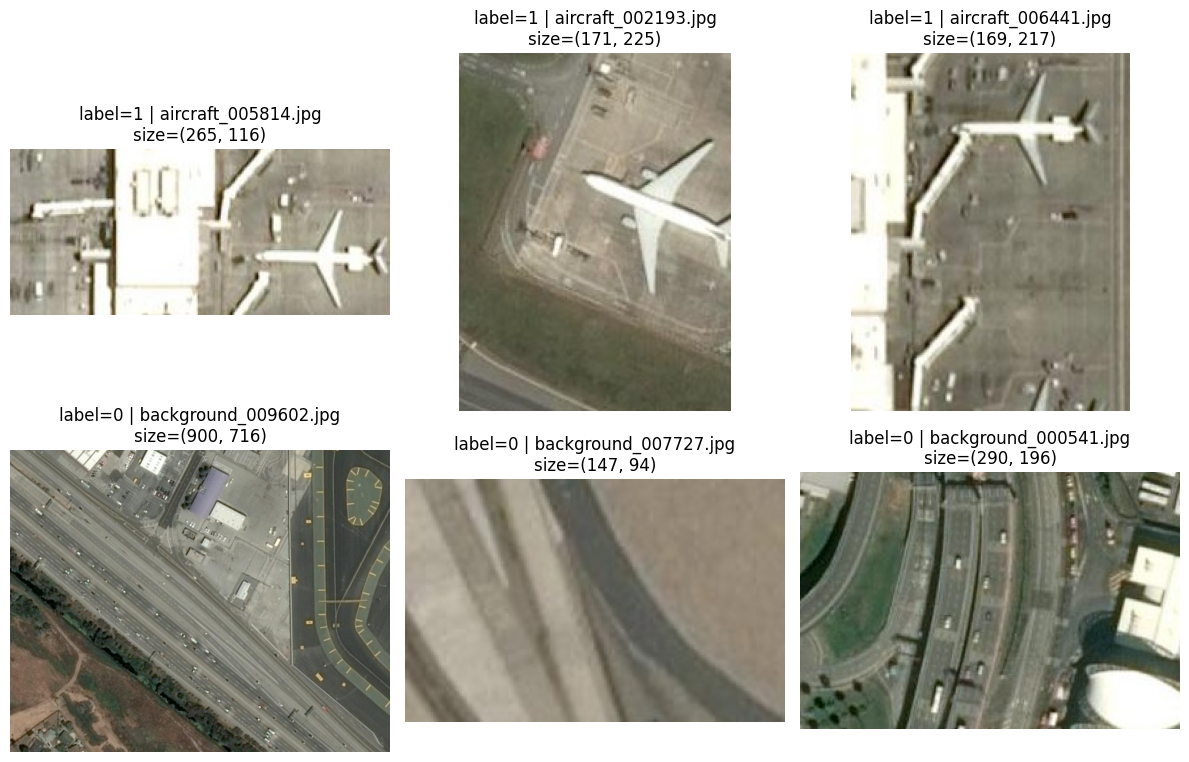

In [8]:
def preview_samples(num_per_class: int = 3) -> None:
    fig, axes = plt.subplots(2, num_per_class, figsize=(4 * num_per_class, 8))
    axes = np.atleast_2d(axes)

    for row_idx, label in enumerate([1, 0]):
        subset = metadata_df[metadata_df["label"] == label]
        if subset.empty:
            continue
        picks = subset.sample(n=min(num_per_class, len(subset)), random_state=rng.randint(0, 10_000))
        for col_idx, (_, sample) in enumerate(picks.iterrows()):
            ax = axes[row_idx, col_idx]
            img_path = OUTPUT_DATASET_DIR / sample["image_path"]
            with Image.open(img_path) as img:
                img_arr = np.array(img)
                img_size = img.size
            ax.imshow(img_arr)
            ax.set_title(f"label={label} | {img_path.name}\nsize={img_size}")
            ax.axis("off")

    plt.tight_layout()


preview_samples(num_per_class=3)



---
**Usage tip:** run the notebook top-to-bottom whenever the upstream Airbus dataset is updated. Toggle `FORCE_OVERWRITE` to rebuild the classification dataset from scratch inside `dataset/airbus-aircrafts-sample-dataset-classification/`. 
